In [2]:
from _utils import *

2024-09-30 12:49:45.681914: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 12:49:46.090401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find lower bound and upper bound of PC1 and PC2 data
l = 0.01
u = 1-l

pc1_l = all_df['PC1'].quantile(l)
pc1_u = all_df['PC1'].quantile(u)
pc2_l = all_df['PC2'].quantile(l)
pc2_u = all_df['PC2'].quantile(u)

num_metastructures = 5

pc1_grid = np.linspace(pc1_l, pc1_u, num_metastructures)
pc2_grid = np.linspace(pc2_l, pc2_u, num_metastructures)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)  

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])   

templates_flatten = metastr_from_pca

measurement_error_esc = np.array([calculate_conformational_variance(esc_maps_interp, x.reshape(80, 80))**0.5 for x in templates_flatten])
measurement_error_cnc = np.array([calculate_conformational_variance(cnc_maps_interp, x.reshape(80, 80))**0.5 for x in templates_flatten])

# Generate log prior for metastructures 
lpm = [(logprior(x, num_monomers)).tolist() for x in templates_flatten]

# Generate log likelihood for observations given metastructures 
# ll_esc = [[(loglikelihood(y, x, z, num_monomers)).tolist() for x, z in zip(templates_flatten, measurement_error_esc)] for y in esc_maps_interp_flat]
# ll_cnc = [[(loglikelihood(y, x, z, num_monomers)).tolist() for x, z in zip(templates_flatten, measurement_error_cnc)] for y in cnc_maps_interp_flat]
    

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [4]:
def calculate_conformational_variance_new(dmap_list, microstates_dmap):
    # This is incorrect because it finds mean across all samples 
    """
    Calculate the conformational variation of a set of distance maps relative to a reference map.

    Parameters:
    dmap_list (list): A list of 2D numpy arrays representing the distance maps.
    dmap_ref (np.ndarray): A 2D numpy array representing the reference distance map.
    num_probes (int): The number of probes in the distance maps.

    Returns:
    np.ndarray: A 2D numpy array containing the variance of the squared Euclidean distances 
               between each distance map and the reference map.
    """
    # Convert dmap_list to a NumPy array
    dmap_list = np.array(dmap_list)
    
    num_microstates = microstates_dmap.shape[0]
    num_probes = np.round(microstates_dmap.shape[1] ** 0.5).astype(int)
    
    dmap_list = dmap_list[:, np.newaxis, :]
    microstates_dmap = microstates_dmap[np.newaxis, :, :]
    
    # Calculate the squared Euclidean distance between each distance map and the reference map
    diff_list = np.sqrt((dmap_list - microstates_dmap) ** 2)
    
    # Calculate the variance along the number of observation/cell dimension
    var = np.var(diff_list, axis=0)
    
    return np.reshape(var, (num_microstates, num_probes, num_probes))

In [5]:
conformation_var_esc = calculate_conformational_variance_new(esc_maps_interp_flat, templates_flatten)

In [6]:
conformation_var_esc**0.5 - measurement_error_esc

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

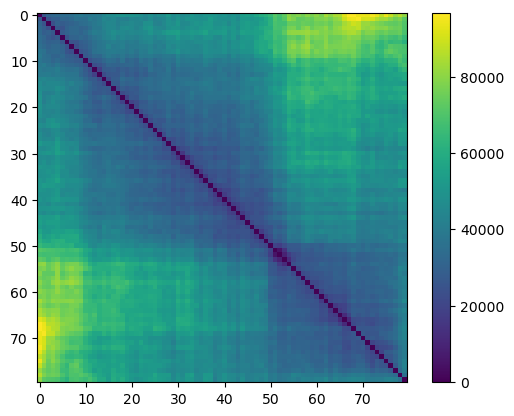

In [96]:
plt.imshow(conformation_var_esc[0])
plt.colorbar()

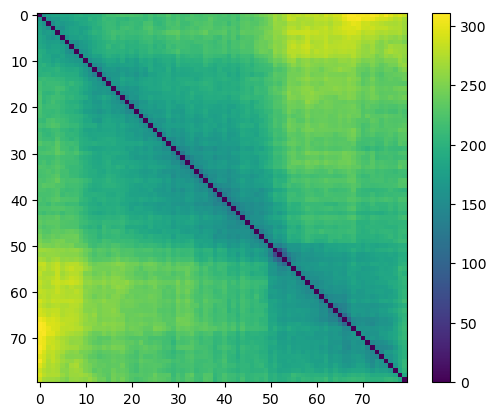

In [97]:
plt.imshow(measurement_error_esc[0])
plt.colorbar()

In [3]:
microstates = jnp.array(templates_flatten)

In [4]:
jnp.array(esc_maps_interp).shape

(1225, 80, 80)

In [5]:
measurement_error_esc.shape

(25, 80, 80)

In [6]:
observed_dmap_flat = esc_maps_interp_flat[np.newaxis, :, :]
microstates_dmap_flat = templates_flatten[:, np.newaxis, :]
measurement_error = measurement_error_esc[:, np.newaxis, :, :]

In [61]:
np.any(microstates_dmap_flat < 0, axis=-1)

array([[ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False]])

In [7]:
observed_dmap_flat.shape, microstates_dmap_flat.shape, measurement_error.shape

((1, 1225, 6400), (25, 1, 6400), (25, 1, 80, 80))

In [8]:
subtraction_map_sq = (observed_dmap_flat - microstates_dmap_flat)**2

In [9]:
subtraction_map_sq_re = subtraction_map_sq.reshape(25, esc_maps_interp_flat.shape[0], 80, 80)

In [10]:
triu_indices = np.triu_indices(80, k=1)

In [11]:
triu_indices

(array([ 0,  0,  0, ..., 77, 77, 78]), array([ 1,  2,  3, ..., 78, 79, 79]))

In [16]:
subtraction_triu = subtraction_map_sq_re[:, :, triu_indices[0], triu_indices[1]]
measurement_error_triu = measurement_error[:, :, triu_indices[0], triu_indices[1]]

In [21]:
np.log(np.sqrt(2*np.pi*measurement_error_triu**2)).shape

(25, 1, 3160)

In [24]:
subtraction_triu.shape

(25, 1225, 3160)

In [57]:
np.sum(np.log(np.sqrt(2*np.pi*measurement_error_triu**2)), axis=-1).shape

(25, 1)

In [26]:
(subtraction_triu/(2*np.square(measurement_error_triu))).shape

(25, 1225, 3160)

In [55]:
(subtraction_triu/(2*np.square(measurement_error_triu))).sum(axis=-1).shape

(25, 1225)

In [58]:
np.where(microstates_dmap_flat <= -1)[0]

array([], dtype=int64)

In [71]:
def loglikelihood_new(observed_dmap_flat, microstates_dmap_flat, measurement_error, num_probes):
    """ 
    """
    num_microstates = microstates_dmap_flat.shape[0]
    num_observations = observed_dmap_flat.shape[0]
    
    # Append a new axis for broadcasting
    observed_dmap_flat = observed_dmap_flat[np.newaxis, :, :]
    microstates_dmap_flat = microstates_dmap_flat[:, np.newaxis, :]
    measurement_error = measurement_error[:, np.newaxis, :, :]
        
    
    # Calculate the difference between distance map and reference 
    # distance map
    subtraction_map_sq = np.square(observed_dmap_flat - microstates_dmap_flat).reshape(num_microstates, num_observations, 
                                                                      num_probes, num_probes)

    # Only consider the upper triangular part of the distance map
    triu_indices = np.triu_indices(num_probes, k=1)
    measurement_error = 2*measurement_error[:, :, triu_indices[0], triu_indices[1]]  # both triangles 
    subtraction_map_sq = 2*subtraction_map_sq[:, :, triu_indices[0], triu_indices[1]]  # both triangles
    
    # Calculate the normalization factor
    normalization_factor = -np.sum(np.log(np.sqrt(2*np.pi*measurement_error**2)), axis=-1)
    
    # Calculate the gaussian term 
    gaussian_term = -np.sum(subtraction_map_sq/(2*np.square(measurement_error)), axis=-1)
    
    # if the reference distance map is not physical ie contains negative values
    # return very low probability: the lowest number numpy can handle
    if np.any(microstates_dmap_flat <= -1):
        unphysical_microstates_indices = np.any(microstates_dmap_flat < 0, axis=-1)
        normalization_factor[unphysical_microstates_indices] = np.iinfo(np.int32).min
        gaussian_term[unphysical_microstates_indices] = np.iinfo(np.int32).min
    
    # Change the dimension so it is compatible with the downstream analysis
    return np.transpose(normalization_factor + gaussian_term)

In [99]:
ll_esc_new = loglikelihood_new(esc_maps_interp_flat, templates_flatten, measurement_error_esc, num_monomers)

In [100]:
ll_esc_new.shape

(1225, 25)

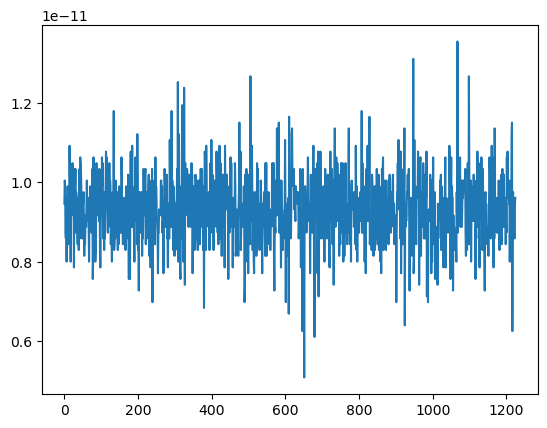

In [101]:
plt.plot((ll_esc_new - np.array(ll_esc)).mean(axis=-1))

In [54]:
np.array(ll_esc).shape

(1225, 25)

In [ ]:
num_cells, _ = esc_maps_interp_flat.shape
subtraction_map_sq = np.square(esc_maps_interp_flat - templates_flatten[0])

In [7]:
subtraction_map_sq_reshape = subtraction_map_sq.reshape(num_cells, num_monomers, num_monomers)

In [11]:
triu_indices = np.triu_indices(num_monomers, k=1)

In [12]:
triu_indices 

(array([ 0,  0,  0, ..., 77, 77, 78]), array([ 1,  2,  3, ..., 78, 79, 79]))

In [13]:
subtraction_map_sq_triu = subtraction_map_sq_reshape[:, triu_indices[0], triu_indices[1]]

In [23]:
measurement_error_esc_triu = np.array(measurement_error_esc)[:, triu_indices[0], triu_indices[1]]

In [27]:
measurement_error_esc_triu.shape

(25, 3160)

In [28]:
normalization_factor = -np.sum(np.log(np.sqrt(2*np.pi*measurement_error_esc_triu**2)), axis=1)
print(normalization_factor)

[-19732.98840164 -19663.28725367 -19615.35213169 -19635.45778619
 -19756.31505557 -19448.46103363 -19351.61553003 -19359.92798558
 -19499.91242399 -19741.1940238  -19412.26671347 -19287.51653245
 -19321.01765358 -19523.23848258 -19806.24935194 -19591.34611585
 -19595.54255549 -19707.45895628 -19870.64577917 -20032.90696933
 -19837.48659495 -19982.29314124 -20169.84908935 -20324.59145332
 -20403.69517683]


In [32]:
gaussian_term = -np.sum(subtraction_map_sq_triu/(2*np.square(measurement_error_esc_triu)), axis=1)
print(gaussian_term)

ValueError: operands could not be broadcast together with shapes (1225,3160) (25,3160) 

In [ ]:
def _loglikelihood_new(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    """ 
    """
    # if the reference distance map is not physical ie contains negative values
    # return very low probability: the lowest number numpy can handle
    if np.any(ref_dmap_flat <= -1):
        return np.iinfo(np.int32).min, np.iinfo(np.int32).min
    
    num_cells, num_probes_sq = dmap_flat.shape 
        
    # Calculate the difference between distance map and reference 
    # distance map
    subtraction_map_sq = np.square(dmap_flat - ref_dmap_flat).reshape(num_cells, num_probes, num_probes)

    # Only consider the upper triangular part of the distance map
    triu_indices = np.triu_indices(num_probes, k=1)
    measurement_error = 2*measurement_error[triu_indices]  # both triangles 
    subtraction_map_sq = 2*subtraction_map_sq[triu_indices]  # both triangles
    
    # Calculate the normalization factor
    normalization_factor = -np.sum(np.log(np.sqrt(2*np.pi*measurement_error**2)))
    
    # Calculate the gaussian term 
    gaussian_term = -np.sum(subtraction_map_sq/(2*np.square(measurement_error)))
    
    return normalization_factor, gaussian_term

In [3]:
ll_esc = np.array(ll_esc)

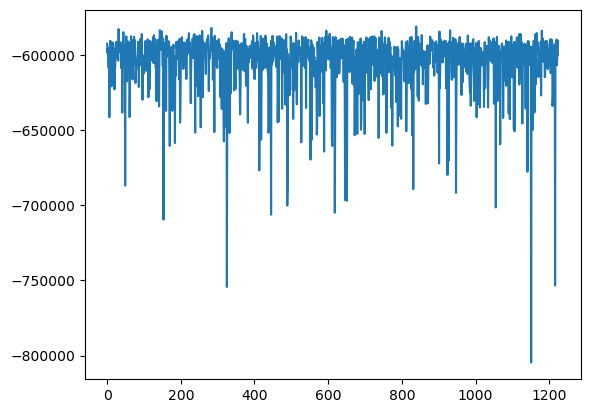

In [4]:
plt.plot(ll_esc.sum(axis=1))

In [8]:
[np.any(x < 0) for x in templates_flatten]

[True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False]

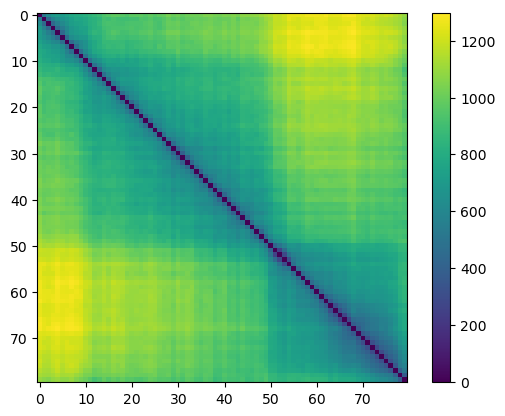

In [10]:
plt.imshow(templates_flatten[0].reshape(80, 80))
plt.colorbar()

In [11]:
np.min(templates_flatten[0].reshape(80, 80)) # This is a very samll nbyumber

-1.2990542416211914e-12

In [3]:
def _logprior(dmap_flat, num_probes):
    """
    """
    # Get 2D map back to simplify the expression 
    dmap = np.reshape(dmap_flat, [num_probes, num_probes])
    
    # Kuhn length is two times the persistence length
    # Persistence length of dsDNA is 50 nm
    b = 2 * 50
    
    # Calculate square of all bond lengths
    R_sq = np.diag(dmap, 1) * b
    
    # Calculate the total number of Kuhn segments 
    # equals to the contour length divided by the Kuhn length
    contour_length = np.sum(np.diag(dmap, 1))
    
    # If contour length is zero or negative, or distance map contains negative values
    # return very low probability: the lowest number numpy can handle
    # if contour_length <= 0 or np.any(dmap < 0):
    #     # This will return the smallest negative number, to reflect the lowest probability
    #     return np.iinfo(np.int32).min, np.iinfo(np.int32).min
    
    N_kuhn = contour_length / b
    print(N_kuhn)
    
    # Calculate the probability
    scaling_factor = 1.5 * N_kuhn * np.log(3/(2*np.pi*b**2))
    gaussian_term = -3*np.sum(R_sq)/(2*b**2)
    
    return scaling_factor, gaussian_term 

In [4]:
np.array(ll_esc).shape

(1225, 25)

In [3]:
lpm = [(logprior(x, num_monomers)).tolist() for x in templates_flatten]

In [4]:
lpm

[-4294967296,
 -4294967296,
 -4294967296,
 -1552.9637136327003,
 -1513.9464713735103,
 -4294967296,
 -4294967296,
 -4294967296,
 -1528.9926743132742,
 -1485.7438733244885,
 -4294967296,
 -4294967296,
 -4294967296,
 -1502.5848518293153,
 -1454.2374276477713,
 -4294967296,
 -4294967296,
 -4294967296,
 -1473.2808099301153,
 -1418.8024188263382,
 -4294967296,
 -4294967296,
 -4294967296,
 -1440.5486593318926,
 -1378.926584767787]

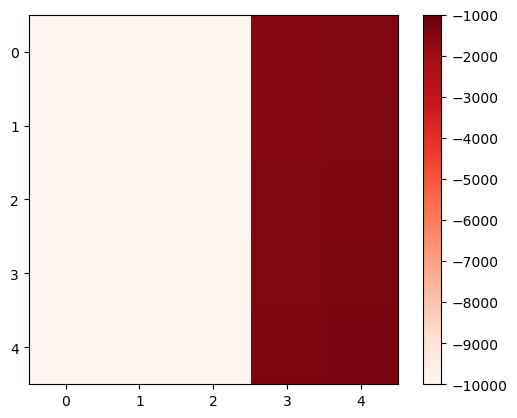

In [6]:
plt.imshow(np.reshape(lpm, [5, 5]), cmap='Reds', vmin=-10000, vmax=-1000)
plt.colorbar()

In [6]:
np.iinfo(np.int32).min

-2147483648

In [7]:
np.array(ll_esc).shape

(1225, 25)

In [20]:
def _loglikelihood_2(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    """ 
    """
    # if the reference distance map is not physical ie contains negative values
    # return very low probability: the lowest number numpy can handle
    # if np.any(ref_dmap_flat < 0):
    #     return np.iinfo(np.int32).min, np.iinfo(np.int32).min
    
    # Calculate the difference between distance map and reference 
    # distance map
    subtraction_map_sq = np.square(dmap_flat - ref_dmap_flat).reshape(num_probes, num_probes)

    # Only consider the upper triangular part of the distance map
    triu_indices = np.triu_indices(num_probes, k=1)
    measurement_error = measurement_error[triu_indices]
    subtraction_map_sq = subtraction_map_sq[triu_indices]
    
    # Calculate the normalization factor
    normalization_factor = -np.sum(np.log(np.sqrt(2*np.pi*measurement_error**2)))
    
    # Calculate the gaussian term 
    gaussian_term = -np.sum(subtraction_map_sq/(2*np.square(measurement_error)))
    
    return normalization_factor, gaussian_term

In [ ]:
def loglikelihood_old(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    """ 
    """
    # Calculate the difference between distance map and reference 
    # distance map
    subtraction_map_sq = np.square(dmap_flat - ref_dmap_flat)
    sum_subtraction_map_sq = np.sum(subtraction_map_sq)
    
    # Calculate the normalization factor
    normalization_factor = -np.square(num_probes) * np.log(np.sqrt(2*np.pi*np.square(measurement_error)))
    
    # Calculate the gaussian term 
    gaussian_term = -np.sum(sum_subtraction_map_sq)/(2*np.square(measurement_error))
    
    return normalization_factor, gaussian_term

In [9]:
num_nonphysical = 0
for x in templates_flatten:
    if np.any(x < 0):
        num_nonphysical += 1

In [10]:
num_nonphysical

15

In [11]:
y = esc_maps_interp_flat[1]
x = templates_flatten[0]
z = measurement_error_esc[0]
num_monomers = 80

In [12]:
triu_indices = np.triu_indices(80, k=1)

In [28]:
ll = ((-(y-x)**2).reshape(80, 80))[triu_indices]/(2*z[triu_indices]**2) + -np.sum(np.log(np.sqrt(2*np.pi*z[triu_indices]**2)))

In [32]:
-np.sum(np.log(np.sqrt(2*np.pi*z[triu_indices]**2)))

-19732.990355778744

In [29]:
ll

array([-19732.99145199, -19735.8879482 , -19733.9789792 , ...,
       -19734.56428898, -19733.89818379, -19733.06641167])

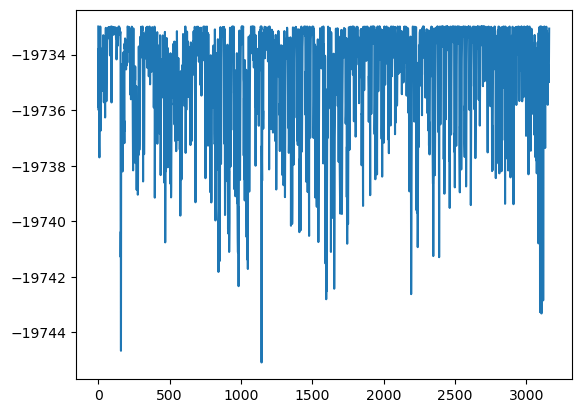

In [30]:
plt.plot(ll)

In [31]:
ll.sum()

-62361829.84274579

In [16]:
n = -np.log(np.sqrt(2*np.pi*np.prod(z[triu_indices]**2)))

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [17]:
np.prod(z[triu_indices]**2)

inf

/tmp/ipykernel_1902791/2500658018.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(((y-x)**2).reshape(80, 80)/(2*z**2))


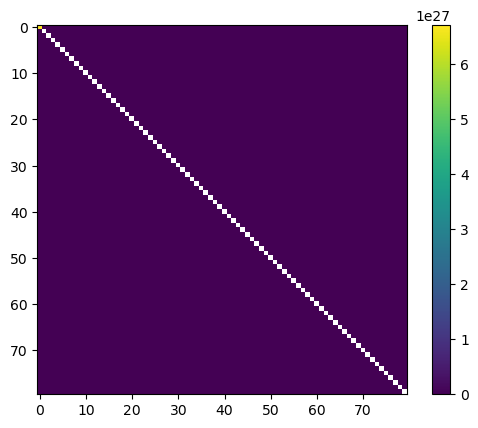

In [18]:
plt.imshow(((y-x)**2).reshape(80, 80)/(2*z**2))
plt.colorbar()

In [19]:
_loglikelihood_2(y, x, z, num_monomers)

[161.32923342 176.80020783 179.97748326 ... 185.1749716  203.05991525
 188.70088405]
[5.70622714e+01 1.81147704e+05 6.40467713e+04 ... 1.07939615e+05
 7.48655427e+04 5.41639984e+03]


(-19732.990355778744, -5580.318484957073)